In [2]:
from bs4 import BeautifulSoup
from tqdm import tqdm

import requests
import wget
import tarfile
import os
import shutil
import time
import networkx as nx
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

/home/mikolaj/.virtualenvs/python3/lib/python3.6/site-packages/requests/__init__.py:80: RequestsDependencyWarning: urllib3 (1.22) or chardet (2.1.1) doesn't match a supported version!
  RequestsDependencyWarning)


In [3]:
def read_avalilable_datasets_konect():
    base_url = "http://konect.uni-koblenz.de/downloads/"
    response = requests.get(base_url)
    
    if response.status_code != 200:
        print("An error occurred while getting data.")
    else:
        html = response.content
        soup = BeautifulSoup(html, "html5lib")
        
        table_html = soup.find(id='sort1')
        
        thead_html = table_html.find('thead')
        tbody_html = table_html.find('tbody')
         
        column_names=[row.text for row in thead_html.findAll('td')]
        rows = tbody_html.findAll('tr')
        values=[[cell.get('href') for cell in value('a') if 'tsv' in cell.get('href')] for value in rows]
        return [val[0].replace('.tar.bz2','').replace('tsv/','') for val in values]
        
def download_tsv_dataset_konect(network_name):
    assert (network_name in read_avalilable_datasets_konect()),"No network named: '"+network_name+"' found in Konect!"
    
    tsv_file = 'http://konect.uni-koblenz.de/downloads/tsv/'+network_name+'.tar.bz2'
    output_file=network_name+'.tar.bz2'
    file_name = wget.download(tsv_file, out=output_file)
    if os.path.exists(output_file):
        shutil.move(file_name,output_file)
    
    return output_file
    
def unpack_tar_bz2_file(file_name):
    tar = tarfile.open("./"+file_name, "r:bz2")
    output_dir="./network_"+file_name.replace('.tar.bz2','')+"/"
    tar.extractall(output_dir)
    tar.close()
    return output_dir

def build_network_from_out_konect(network_name):
    file_name=download_tsv_dataset_konect(network_name=network_name)
    output_dir=unpack_tar_bz2_file(file_name)+network_name+"/"
    files = [file for file in os.listdir(output_dir) if os.path.isfile(os.path.join(output_dir, file))]
    out_file = [file for file in files if 'out.' in file]
    assert (len(out_file)>0), 'No out. file in the directory.'
    
    #building network
    G=nx.read_adjlist(output_dir+out_file[0], comments='%')
    
    return G

In [4]:
networks_names=[
 'moreno_beach',
 'moreno_bison',
 'moreno_blogs',
 'moreno_cattle',
 'moreno_crime',
 'moreno_health',
 'moreno_highschool',
 'moreno_innovation',
 'moreno_kangaroo',
 'moreno_lesmis',
 'moreno_mac',
 'moreno_names',
 'moreno_oz',
 'moreno_propro',
 'moreno_rhesus',
 'moreno_sampson',
 'moreno_seventh',
 'moreno_sheep',
 'moreno_taro',
 'moreno_train',
 'moreno_vdb',
 'moreno_zebra',
]

In [5]:
networks=[]
for network_name in tqdm(networks_names):
    networks.append(build_network_from_out_konect(network_name))

 50%|█████     | 11/22 [00:09<00:09,  1.20it/s]/home/mikolaj/.virtualenvs/python3/lib/python3.6/site-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)
100%|██████████| 22/22 [00:19<00:00,  1.14it/s]


In [6]:
network_stats = []

for (name, network) in zip(networks_names, networks):
    network_stats.append((name, 
                          network.number_of_nodes(), 
                          np.round(network.number_of_edges()/network.number_of_nodes(), 2)))
    
network_data=pd.DataFrame(network_stats, columns=['network name', 'number of vertices', 'average degree'])

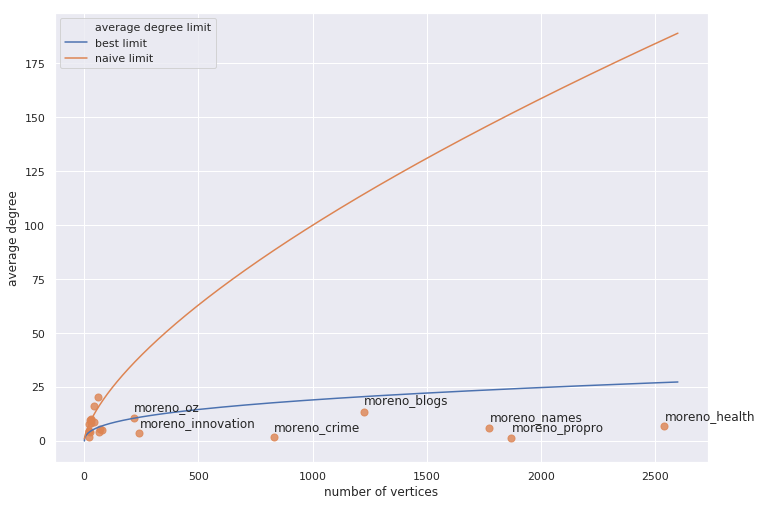

In [13]:
x = range(1,2600)
y1 = np.power(x*np.log(x), 1/3)
y2 = np.power(x, 2/3)

df = pd.DataFrame({
    'num vertices': x,
    'best limit': y1,
    'naive limit': y2
}).melt(id_vars=['num vertices'], var_name='average degree limit')

sns.set(rc={'figure.figsize':(11.7,8.27)})


figure = sns.lineplot(data=df, x='num vertices', y='value', hue='average degree limit')



plt.xlabel('number of vertices')
plt.ylabel('average vertex degree')


ax=sns.regplot(x=network_data['number of vertices'], 
               y=network_data['average degree'], 
               scatter=True, 
               fit_reg=False, 
               marker='o',
               scatter_kws={"s": 50}) 
# the "s" key in `scatter_kws` modifies the size of the marker

network_data_labels = network_data[network_data['number of vertices'] > 200]

[ ax.text(p[0]+2, p[1]+3, p[2]) for p in zip(network_data_labels['number of vertices'], 
                                             network_data_labels['average degree'], 
                                             network_data_labels['network name'])]

plt.show(figure)

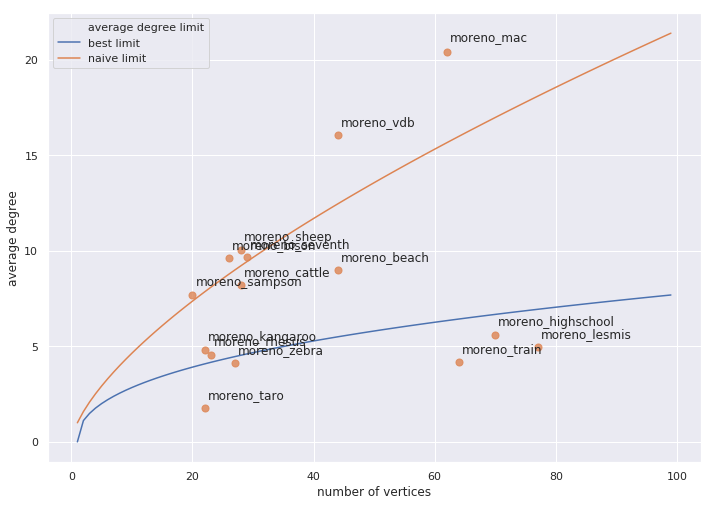

In [20]:
x = range(1,100)
y1 = np.power(x*np.log(x), 1/3)
y2 = np.power(x, 2/3)

df = pd.DataFrame({
    'num vertices': x,
    'best limit': y1,
    'naive limit': y2
}).melt(id_vars=['num vertices'], var_name='average degree limit')

sns.set(rc={'figure.figsize':(11.7,8.27)})

small = network_data['number of vertices'] < 100

figure = sns.lineplot(data=df, x='num vertices', y='value', hue='average degree limit')

plt.xlabel('number of vertices')
plt.ylabel('average vertex degree')

ax=sns.regplot(x=network_data[small]['number of vertices'], 
               y=network_data[small]['average degree'], 
               scatter=True, 
               fit_reg=False, 
               marker='o',
               scatter_kws={"s": 50}) 
# the "s" key in `scatter_kws` modifies the size of the marker

network_data_labels = network_data[network_data['number of vertices'] < 100]

[ ax.text(p[0]+0.5, p[1]+0.5, p[2]) for p in zip(network_data_labels['number of vertices'], 
                                             network_data_labels['average degree'], 
                                             network_data_labels['network name'])]

plt.show(figure)